In [100]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/M2_S1/amal/tme4/student_tp4/src

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/M2_S1/amal/tme4/student_tp4/src


In [129]:
from utils import RNN, device, SampleMetroDataset, ForecastMetroDataset
import torch
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

#Longueur des séquences
LENGTH = 30
# Dimension de l'entrée (1 (in) ou 2 (in/out))
#Taille du batch
BATCH_SIZE = 32

PATH = "../../data/"

import string
import unicodedata
import sys


## Liste des symboles autorisés
LETTRES = string.ascii_letters + string.punctuation+string.digits+' '
## Dictionnaire index -> lettre
id2lettre = dict(zip(range(1,len(LETTRES)+1),LETTRES))
id2lettre[0]='' ##NULL CHARACTER
## Dictionnaire lettre -> index
lettre2id = dict(zip(id2lettre.values(),id2lettre.keys()))

def normalize(s):
    """ Nettoyage d'une chaîne de caractères. """
    return ''.join(c for c in unicodedata.normalize('NFD', s) if  c in LETTRES) # eneler les accents ect

def string2code(s):
    """ Transformation d'une chaîne de caractère en tenseur d'indexes """
    return torch.tensor([lettre2id[c] for c in normalize(s)]) # hello -> [1 2 3 3 9] par exp

def code2string(t):
    """ Transformation d'une liste d'indexes en chaîne de caractères """
    if type(t) !=list:
        t = t.tolist()
    return ''.join(id2lettre[i] for i in t)

class TrumpDataset(Dataset):
    def __init__(self,text,maxsent=None,maxlen=None):
        """  Dataset pour les tweets de Trump
            * text : texte brut
            * maxsent : nombre maximum de phrases.
            * maxlen : longueur maximale des phrases.
        """
        maxlen = maxlen or sys.maxsize
        full_text = normalize(text)
        self.phrases = [p[:maxlen].strip()+"." for p in full_text.split(".") if len(p)>0]
        if maxsent is not None:
            self.phrases=self.phrases[:maxsent]
        self.MAX_LEN = max([len(p) for p in self.phrases])

    def __len__(self):
        return len(self.phrases)
    def __getitem__(self,i):
        t = string2code(self.phrases[i])
        t = torch.cat([torch.zeros(self.MAX_LEN-t.size(0),dtype=torch.long),t])
        return t[:-1],t[1:]



MAX_LEN = 30

data_trump = DataLoader(TrumpDataset(open(PATH+"trump_full_speech.txt","rb").read().decode(),maxlen=MAX_LEN), batch_size= BATCH_SIZE, shuffle=True)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**Remarque**: Il semble que moins il y a de zero dans la sequence, meilleur est le résultat géneré

In [130]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [137]:
HIDDEN = 60
lr = 0.01
NB_EPOCH = 10
DIM_INPUT = len(lettre2id)
model = RNN(in_dim=DIM_INPUT, out_dim=DIM_INPUT, hidden=HIDDEN).to(device) # forecast n from n -> out = in
optim = torch.optim.Adam(params=model.parameters(),lr=lr)
loss = torch.nn.CrossEntropyLoss()

In [138]:
import matplotlib.pyplot as plt
import numpy as np

Epoch 1


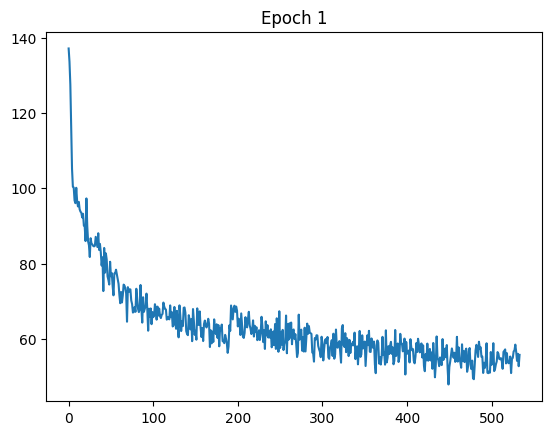

Epoch 2


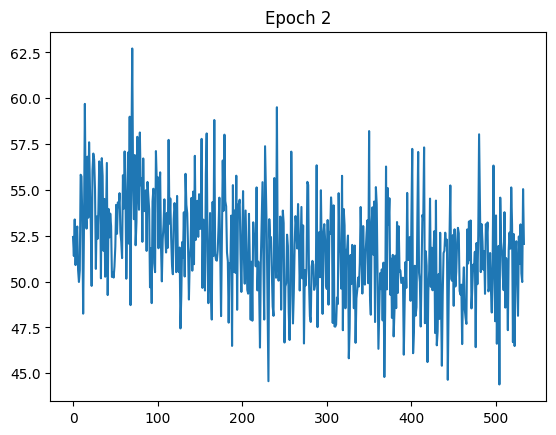

Epoch 3


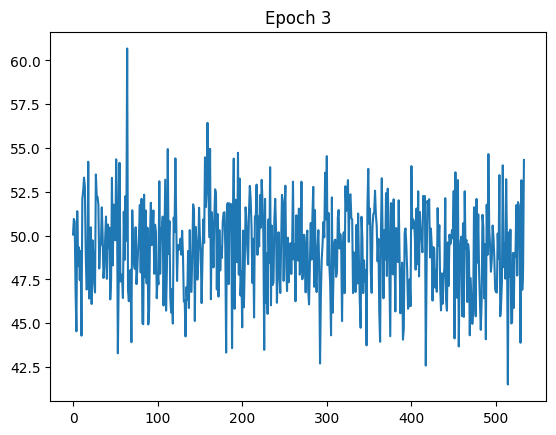

Epoch 4


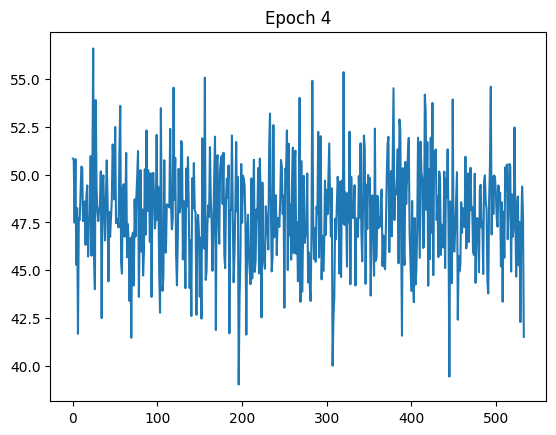

Epoch 5


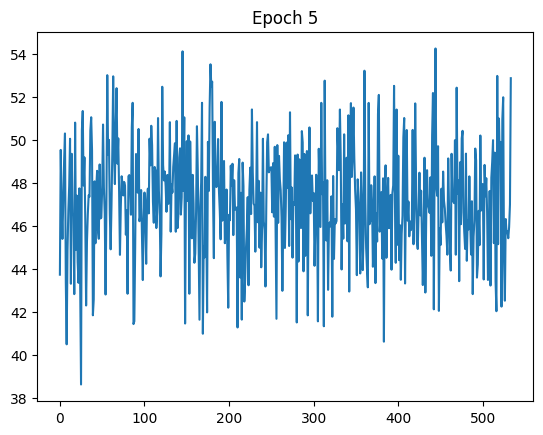

Epoch 6


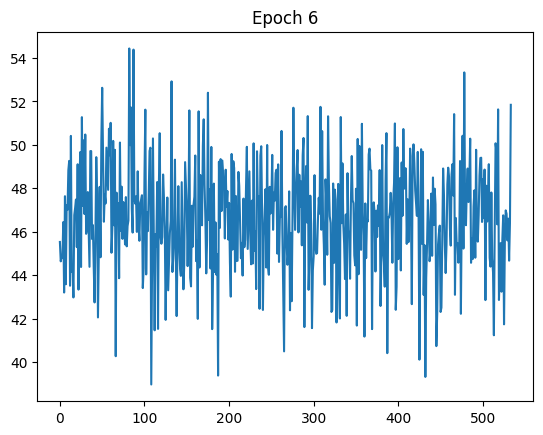

Epoch 7


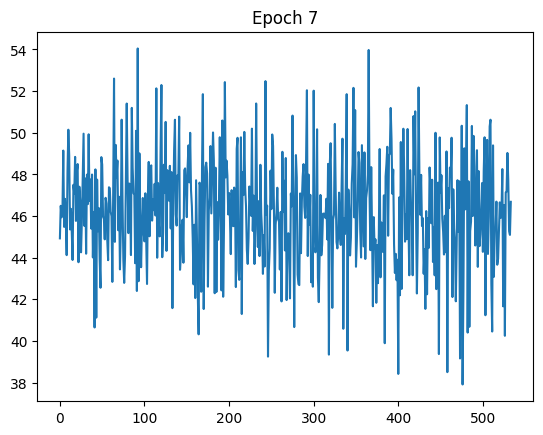

Epoch 8


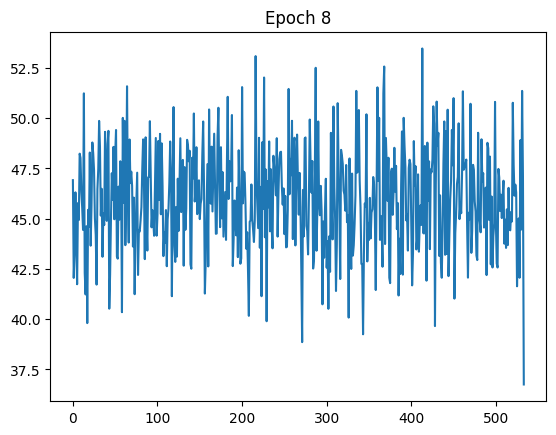

Epoch 9


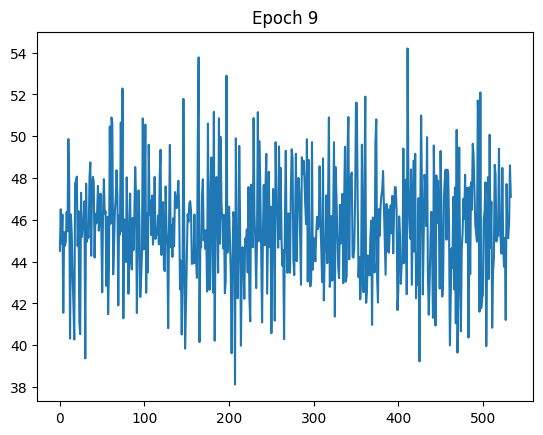

Epoch 10


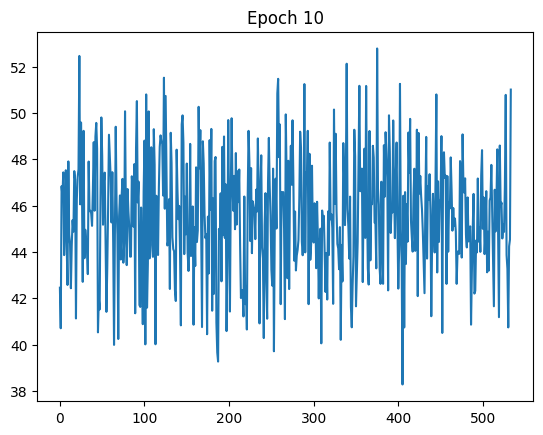

In [139]:
from math import e
# 0 - plot, 1 - chiffre
mode = 0
for epoch in range(NB_EPOCH):
    print(f'Epoch {epoch+1}')
    loss_epoch = []
    nb_b = 0
    for x, y in data_trump:
        nb_b += 1
        x = torch.nn.functional.one_hot(x, num_classes=DIM_INPUT)
        x = torch.transpose(x, dim0=0, dim1=1) # len 1er, batch 2eme
        y = torch.transpose(y, dim0=0, dim1=1) # cross entropy -> pas besoin de one hot y (batch, len) ->(len, batch)
        y = y.to(device)
        #y = y.type(torch.float32)
        bz = x.shape[1]
        x = x.to(device)
        h = model.init_h0(bz)
        x = x.type(h.dtype)
        h = h.to(device)
        h = model.forward(x, h)
        h = h.to(device)
        ypred = model.decode(h)


        # ypred = torch.reshape(ypred, (x.shape[0]*x.shape[1], -1))
        # y = torch.reshape(y, (x.shape[0]*x.shape[1],))
        optim.zero_grad()
        l = 0
        for i in range(len(ypred)):
            l += loss(ypred[i], y[i])
        loss_epoch.append(l.detach())
        l.backward()
        optim.step()
    if mode == 0:
      plt.plot(np.arange(0,nb_b),np.asarray(loss_epoch))
      plt.title(f"Epoch {epoch+1}")
      plt.show()
    else:
      print("Loss training: ", (sum(loss_epoch)/len(loss_epoch)).item())

In [152]:
out_text = []

# creer le debut de la sequence
x = string2code("A")
out_text.append(x.item())
x = torch.nn.functional.one_hot(x, num_classes=DIM_INPUT) # one hot
x = torch.unsqueeze(x, dim=0) # add 1 dim for Len seq


len_gen = 300
batch_size = 1
# ini H
h = model.init_h0(batch_size)
x = x.type(h.dtype)
for _ in range(len_gen):
  # predire
  h = model.forward(x, h)
  res = model.decode(h)
  res = torch.nn.Softmax(dim=-1)(res)
  dist = torch.distributions.categorical.Categorical(probs=res)
  # sample de la distribution
  inx_char = dist.sample()
  # feed le resultat dans le reseau
  x = torch.nn.functional.one_hot(inx_char, num_classes=DIM_INPUT)
  x = x.type(h.dtype)
  # ajouter le char prédit dans la liste des inx
  out_text.append(inx_char[0].item())

# afficher le text
code2string(out_text)

'A China ed paytary," America ppi.en.on ne.m bestse ca.rep lob-mut aleet new NAstor used guini,00 over it. a crimilos.eses, from gover a.limany will rechinaly,.y our numper mule a Trump.ridu, up equargan want ever the plan this.ly uss are people adminn way golivio nee one, there we rest.ted we needs a'